# Problem Set 3 - Advanced Macroeconomics

## Victor Hugo C. Alexandrino da Silva

### October 2020

#### Insper Institute of Economic and Research


In this Problem Set I am going to replicate the Section 5.2. Kitao (2008), in an exercise that reduces the tax on entrepreneurial business income.

First, let's call the Python libraries for this exercise. Again, we are going to use the Quantecon (https://quantecon.org) framework and libraries.

In [1]:
!conda install -y quantecon

Solving environment: done

# All requested packages already installed.



In [2]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import quantecon as qe
import math
from copy import deepcopy
import seaborn as sns
from numpy import interp
from datetime import datetime

Now, we calibrate the model using Kitao (2008) parameters, together with the grid settings. 

In [4]:
# Parameters for productivity shocks
m = 1
n = 5
tauchen_approx_z = qe.markov.approximation.tauchen(0.94, math.sqrt(0.02), m =m,n=n)

# Rest of the parameters
gamma = 2
beta  = 0.9428
alpha = 0.36
delta = 0.06
hours = 1
phi   = 0.05
nu    = 0.88
tau_c = 0.0567
tau_i = 0.0316
tau_e = 0.10
a_0   = 0.258
a_1   = 0.768
a_2   = 0.438
d     = 0.5

# Create Grids

# Assets
grid_min  = 1e-3
grid_max  = 200
grid_size = 300
step = (grid_max-grid_min)/grid_size
a = np.linspace(grid_min, grid_max, grid_size)
a_grid = grid_size

#Productivity
z_grid = 5
pi_z = tauchen_approx_z.P #transition matrix
z = tauchen_approx_z.state_values # state values
z = np.exp(z) # exp so we don't have negative values
pi_z_inv = tauchen_approx_z.stationary_distributions


#Creating my own markov chain for the entrepreneur hability
s_grid = 4
pi_s = np.matrix([[0.78,0.22,0,0],
                [0.43,0.42,0.15,0],
                [0,0.43,0.42,0.15],
                [0,0,0.22,0.78]])#transition matrix
s = np.array([0,0.706,1.47,2.234]) # state values # exp so we don't have negative values
pi_s_inv = (pi_s**1000)[1,:]


N = 0
for i in range(z_grid):
    N = N + hours*z[i]*pi_z_inv[0][i]

Note that $\tau_e = 10\%$ is our beginning entrepreneurial business income.

Moreover, for this exercise we only set the asset grid to 200, due to computational boundary. The results are similar to original Kitao (2008) results.

Now, defining the utility functions and other definitions for our quantitative exercise. Note that we use the Numba library in order to faster the code.

In [5]:
#Define the functions
@jit("float64(float64)",nopython = True)
def u(x):
    if gamma == 1:
        return(math.log(x))
    else:
        return (x**(1-gamma))/(1-gamma)

# Grid for k and n that entrepreneur will choose
k_grid = 100
n_grid = 100
k = np.linspace(0, (1.5*grid_max), k_grid)
n = np.linspace(0, grid_max, n_grid)

@jit
def income_tax(I):
    return a_0*(I - (I**(-a_1) + a_2)**(-1/a_1)) + tau_i*I

@jit
def income_tax_ent(I1,I2,tau_e):
    return a_0*(I2 - (I2**(-a_1) + a_2)**(-1/a_1)) + tau_i*I2 + tau_e*I1

@jit(nopython = True,nogil=True)
def profit(a,z,s,prof,r,w, alpha = alpha, phi = phi, d= d,tau_e=tau_e):
    for ja in range(a_grid):
        for jz in range(z_grid):
            for js in range(s_grid):
                k = np.linspace(0, (1.5*a[ja]), k_grid)
                n = np.linspace(0, max(5*z[jz],a[ja]), n_grid)
                k_test = np.where(k>(1+d)*a[ja],(1+d)*a[ja],k)
                k_test_1 = np.power(k_test,alpha)
                n_test_1 = np.power(n,(1-alpha))
                r_tilde = np.repeat(r,k_grid)
                r_tilde = np.where(k>a[ja],r+phi,r_tilde)
                prod = np.outer(k_test_1,n_test_1)
                prod = s[js]*np.power(prod,nu)
                k_test_2 = ((1-delta)*k_test - (1+r_tilde)*(k_test-a[ja]))
                k_test_2 = np.repeat(k_test_2,k_grid).reshape(k_grid,k_grid)
                n_test_2 = (-w*np.where(n-z[jz]<0,0,n-z[jz]))
                n_test_2 = np.repeat(n_test_2,n_grid).reshape(n_grid,n_grid).T
                prof_test = prod + k_test_2 + n_test_2
                taxable_income_1 = prod - delta*k_test - r*k_test - phi*np.where(k_test-a[ja]<0,0,k_test-a[ja]) + n_test_2
                taxable_income_1 = np.where(taxable_income_1<0,0,taxable_income_1)
                taxable_income_2 = r*a[ja]
                taxes = income_tax_ent(taxable_income_1,taxable_income_2,tau_e)
                prof_test_1 = prof_test - taxes
                prof[ja,jz,js] = np.max(prof_test_1)
    

@jit(nopython = True)
def utility_worker(util_worker, r, w):
    for ja in range(a_grid):
        for jz in range(z_grid):
            for js in range(s_grid):
                for ka in range(a_grid):
                    I = w*z[jz] + r*a[ja]
                    c = ((1+r)*a[ja] + w*hours*z[jz] - a[ka] - income_tax(I))/(1+tau_c)
                    if (c>0):
                        util_worker[ja,jz,js,ka] = u(c)
                    else:
                        util_worker[ja,jz,js,ka] = -100000000

@jit(nopython = True)
def utility_entrepreneur(util_ent, r, w, prof):
    for ja in range(a_grid):
        for jz in range(z_grid):
            for js in range(s_grid):
                for ka in range(a_grid):
                    c = (prof[ja,jz,js] - a[ka])/(1+tau_c)
                    if (c>0):
                        util_ent[ja,jz,js,ka] = u(c)
                    else:
                        util_ent[ja,jz,js,ka] = -100000000


@jit
def update_worker(V_worker,V_ent,V_worker_new,ga_worker,gc_worker,ind_a_worker,worker_array_worker,r,w):
    for ja in range(a_grid):
        for jz in range(z_grid):
            for js in range(s_grid):
                vtemp_worker = np.repeat(-math.inf,a_grid)
                vtemp_ent = np.repeat(-math.inf,a_grid)
                for ka in range(a_grid):
                    EV_worker = 0
                    EV_ent    = 0
                    for kz in range(z_grid):
                        for ks in range(s_grid):
                            EV_worker = EV_worker + pi_s[js,ks]*pi_z[jz,kz]*V_worker[ka,kz,ks]
                            EV_ent = EV_ent + pi_s[js,ks]*pi_z[jz,kz]*V_ent[ka,kz,ks]
                    vtemp_worker[ka] = util_worker[ja,jz,js,ka] + beta*EV_worker
                    vtemp_ent[ka] = util_worker[ja,jz,js,ka] + beta*EV_ent
                V_max_worker = max(vtemp_worker)
                V_max_ent = max(vtemp_ent)
                if V_max_worker>V_max_ent:
                    worker_array_worker[ja,jz,js] = 1
                    vtemp = vtemp_worker
                    V_max = V_max_worker
                else:
                    worker_array_worker[ja,jz,js] = 0
                    vtemp = vtemp_ent
                    V_max = V_max_ent
                temp_list = list(vtemp)
                ind_a_worker[ja,jz,js]  = int(temp_list.index(max(temp_list)))
                V_worker_new[ja,jz,js] = V_max
                ga_worker[ja,jz,js] = a[int(ind_a_worker[ja,jz,js])]
                I = w*z[jz] + r*a[ja]
                gc_worker[ja,jz,js] = ((1+r)*a[ja]+w*hours*z[jz] - ga_worker[ja,jz,js] - income_tax(I))/(1+tau_c)


@jit
def update_ent(V_ent,V_worker,V_ent_new,ga_ent,gc_ent,ind_a_ent,worker_array_ent,r,w):
    for ja in range(a_grid):
        for jz in range(z_grid):
            for js in range(s_grid):
                vtemp_worker = np.repeat(-math.inf,a_grid)
                vtemp_ent = np.repeat(-math.inf,a_grid)
                for ka in range(a_grid):
                    EV_worker = 0
                    EV_ent    = 0
                    for kz in range(z_grid):
                        for ks in range(s_grid):
                            EV_worker = EV_worker + pi_s[js,ks]*pi_z[jz,kz]*V_worker[ka,kz,ks]
                            EV_ent = EV_ent + pi_s[js,ks]*pi_z[jz,kz]*V_ent[ka,kz,ks]
                    vtemp_worker[ka] = util_ent[ja,jz,js,ka] + beta*EV_worker
                    vtemp_ent[ka] = util_ent[ja,jz,js,ka] + beta*EV_ent
                V_max_worker = max(vtemp_worker)
                V_max_ent = max(vtemp_ent)
                if V_max_worker>V_max_ent:
                    worker_array_ent[ja,jz,js] = 1
                    vtemp = vtemp_worker
                    V_max = V_max_worker
                else:
                    worker_array_ent[ja,jz,js] = 0
                    vtemp = vtemp_ent
                    V_max = V_max_ent
                temp_list = list(vtemp)
                ind_a_ent[ja,jz,js]  = int(temp_list.index(max(temp_list)))
                V_ent_new[ja,jz,js] = V_max
                ga_ent[ja,jz,js] = a[int(ind_a_ent[ja,jz,js])]
                gc_ent[ja,jz,js] = (prof[ja,jz,js]  - ga_ent[ja,jz,js])/(1+tau_c)




# Function for generating the hability shocks
@jit
def mc_sample_path(pi_s, sample_size, ψ_0=None):
    # set up
    pi_s = np.asarray(pi_s)
    X = np.empty(sample_size, dtype=int)
    # Convert each row of P into a cdf
    n = len(pi_s)
    P_dist = [np.cumsum(pi_s[i, :]) for i in range(n)]
    # draw initial state, defaulting to 0
    if ψ_0 is not None:
        X_0 = qe.random.draw(np.cumsum(ψ_0))
    else:
        X_0 = 0
    # simulate
    X[0] = X_0
    for t in range(sample_size - 1):
        X[t+1] = qe.random.draw(P_dist[X[t]])

    return X

# Function for updating individual households once we populate the economy
@jit(nopython = True)
def update_individual(household_asset,household_cons,
                      tauchen_sim_z,tauchen_sim_s,
                      ga_worker_interp,ga_ent_interp,gc_worker_interp,gc_ent_interp,
                      a_interp,z,s,
                      worker_history,worker_array_worker,worker_array_ent):
    for t in range(1,sim_size):
        x = np.where(a_interp == household_asset[t-1])[0][0]
        y = np.where(z == tauchen_sim_z[t])[0][0]
        q = np.where(s == tauchen_sim_s[t])[0][0]
        if worker_history[t-1] == 1:
            worker = worker_array_worker
            ga = ga_worker_interp
            gc = gc_worker_interp
        else:
            worker = worker_array_ent
            ga = ga_ent_interp
            gc = gc_ent_interp
            
        household_asset[t] = ga[x,y,q]
        household_cons[t] = gc[x,y,q]
        worker_history[t] = worker[x,y,q]

# Function for generating a population
@jit
def populate(number_ind,sim_size,tauchen_approx_z,pi_s,z,s):
    for ind in range(0,number_ind):
        tauchen_sim_z = tauchen_approx_z.simulate(sim_size)
        tauchen_sim_z = np.exp(tauchen_sim_z)
        sim_s_2 = mc_sample_path(pi_s, sample_size=sim_size, ψ_0=None)
        sim_s = sim_s_2.astype(float)
        for i in range(len(sim_s)):
            sim_s[i] = s[sim_s_2[i]]
        tauchen_sim_s = sim_s
        household_asset = np.repeat(a[0],sim_size).astype(float)
        household_cons = np.repeat(0,sim_size).astype(float)
        worker_history = np.repeat(1,sim_size).astype(int)
        temp_house = [household_asset, household_cons, tauchen_sim_z,tauchen_sim_s,worker_history]
        update_individual(household_asset,household_cons,
                              tauchen_sim_z,tauchen_sim_s,
                              ga_worker,ga_ent,gc_worker,gc_ent,
                              a,z,s,
                              worker_history,worker_array_worker,worker_array_ent)
        test[:,0,ind] = temp_house[0]
        test[:,1,ind] = temp_house[1]
        test[:,2,ind] = temp_house[4]

# Function to obtain aggregate assets and households assets from the populated world
@jit
def Am_test_update(Am_test, test):
    for t in range(0,sim_size):
        for i in range(0,number_ind):
            Am_test[t,0] = Am_test[t,0] + test[t,0,i]
            Am_test[t,i] = test[t,0,i]

The next step is to iterate until the equilibrium:

In [6]:
erro_k = 100
iter_k = 0
r      = 0.04
r_new  = 0.04
ind_a  = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(int)
prof   = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(float)


#worker grids
V_worker     = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(float)
V_worker_new = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(float)
ga_worker    = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(float)
gc_worker    = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(float)
util_worker  = np.repeat(0,a_grid*z_grid*s_grid*a_grid).reshape(a_grid,z_grid,s_grid,a_grid).astype(float)
ind_a_worker = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(int)

#entrepreneur grids
V_ent     = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(float)
V_ent_new = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(float)
ga_ent    = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(float)
gc_ent    = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(float)
util_ent  = np.repeat(0,a_grid*z_grid*s_grid*a_grid).reshape(a_grid,z_grid,s_grid,a_grid).astype(float)
ind_a_ent = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(int)

#Grid for choice between being worker and entrepreneur: if 1, he chooses to be a worker
worker = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(int)
worker_array_ent = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(int)
worker_array_worker = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(int)


# Interpolation grid
a_interp = np.linspace(grid_min, grid_max, 3*grid_max)
ga_worker_interp = np.repeat(0,3*grid_max*z_grid*s_grid).reshape(3*grid_max,z_grid,s_grid).astype(float)
gc_worker_interp = np.repeat(0,3*grid_max*z_grid*s_grid).reshape(3*grid_max,z_grid,s_grid).astype(float)
ga_ent_interp = np.repeat(0,3*grid_max*z_grid*s_grid).reshape(3*grid_max,z_grid,s_grid).astype(float)
gc_ent_interp = np.repeat(0,3*grid_max*z_grid*s_grid).reshape(3*grid_max,z_grid,s_grid).astype(float)


start_time = datetime.now()
while abs(erro_k)>1e-2 and iter_k<100:
    iter_k = iter_k + 1
    erro_v_worker = 100
    erro_v_ent = 100
    iter_v = 0
    r = 0.9*r + 0.1*r_new
    K = ((alpha*(N**(1-alpha)))/(r+delta))**(1/(1-alpha))
    Y = (K**alpha)*(N**(1-alpha))
    w = (1-alpha)*(K**(alpha)*N**(-alpha))
    profit(a,z,s,prof,r,w, alpha = alpha, phi = phi, d= d)
    utility_entrepreneur(util_ent, r, w,prof)
    utility_worker(util_worker, r, w)
    while (erro_v_worker > 1e-3 or erro_v_ent > 1e-3) and iter_v<200:
        update_ent(V_ent,V_worker,V_ent_new,ga_ent,gc_ent,ind_a_ent,worker_array_ent,r,w)
        update_worker(V_worker,V_ent,V_worker_new,ga_worker,gc_worker,ind_a_worker,worker_array_worker,r,w)
        erro_v_worker = np.max(abs(V_worker_new - V_worker))
        erro_v_ent = np.max(abs(V_ent_new - V_ent))
        # print(iter_v)
        # print(erro_v_worker)
        # print(erro_v_ent)
        # print("----------//------------")
        iter_v = iter_v + 1
        V_worker = deepcopy(V_worker_new)
        V_ent = deepcopy(V_ent_new)
    
    
    for jz in range(z_grid):
        for js in range(s_grid):
            ga_worker_interp[:,jz,js] = np.interp(a_interp, a, ga_worker[:,jz,js])
            gc_worker_interp[:,jz,js] = np.interp(a_interp, a, gc_worker[:,jz,js])
            ga_ent_interp[:,jz,js]    = np.interp(a_interp, a, ga_ent[:,jz,js])
            gc_ent_interp[:,jz,js]    = np.interp(a_interp, a, gc_ent[:,jz,js])
    
    # Create Household parameters and populate world
    sim_size = 600
    household_asset = np.repeat(0.001,sim_size).astype(float)
    household_cons = np.repeat(0,sim_size).astype(float)
    number_ind = 5000
    # test = list()
    test = np.repeat(0,sim_size*number_ind*3).reshape(sim_size,3,number_ind).astype(float)
    populate(number_ind,sim_size,tauchen_approx_z,pi_s,z,s)
    
    # Obtain Aggregate data
    Am_test = np.repeat(0,sim_size*number_ind).reshape(sim_size,number_ind).astype(float)
    Am_test_update(Am_test, test)
    Am = Am_test[sim_size-1,0]/number_ind

    erro_k = (K-Am)/K
    K = Am
    r_new = alpha*((K/N)**(alpha-1))-delta
    
    
    print("erro_k = "+str(erro_k))
    print("iter_k = "+str(iter_k))
    print("r_new = "+str(r_new))
    print("r = "+str(r))
    print("Am = "+str(Am))
    print("savings rate is "+ str(delta*alpha/(r+delta)))
    print("--------------------------------")

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

<ipython-input-5-43dea98d146d>:191: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "populate" failed type inference due to: non-precise type pyobject
During: typing of argument at <ipython-input-5-43dea98d146d> (193)

File "<ipython-input-5-43dea98d146d>", line 193:
def populate(number_ind,sim_size,tauchen_approx_z,pi_s,z,s):
    for ind in range(0,number_ind):
    ^

  @jit
<ipython-input-5-43dea98d146d>:191: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "populate" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-5-43dea98d146d>", line 193:
def populate(number_ind,sim_size,tauchen_approx_z,pi_s,z,s):
    for ind in range(0,number_ind):
    ^

  @jit
/Users/victoralexandrino/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numba/core/object_mode_passes.py:177: NumbaWarning: Function "populate" was c

erro_k = -0.8453780638459606
iter_k = 1
r_new = 0.007562447458680913
r = 0.04000000000000001
Am = 14.174975952508671
savings rate is 0.21599999999999997
--------------------------------
erro_k = -0.43419961993443035
iter_k = 2
r_new = 0.016815499410041387
r = 0.036756244745868104
Am = 11.599069099665545
savings rate is 0.22324140479751728
--------------------------------
erro_k = -0.19193061584865354
iter_k = 3
r_new = 0.02469043705921195
r = 0.034762170212285434
Am = 9.958542185283987
savings rate is 0.2279390599815502
--------------------------------
erro_k = -0.1267347067670829
iter_k = 4
r_new = 0.026861745764379774
r = 0.033754996896978084
Am = 9.572323380601691
savings rate is 0.23038772028049856
--------------------------------
erro_k = -0.1299907232803482
iter_k = 5
r_new = 0.02606401340691407
r = 0.033065671783718255
Am = 9.711319341136829
savings rate is 0.23209417163180998
--------------------------------
erro_k = -0.039586662180726824
iter_k = 6
r_new = 0.0300987915814689
r

Now, defining a function that obtain the share of entrepreneurs:

In [7]:
@jit
def ent_share_update(ent_share, test):
    for t in range(0,sim_size):
        for i in range(0,number_ind):
            ent_share[t,0] = ent_share[t,0] + test[t,2,i]
            ent_share[t,i] = test[t,2,i]


ent_share = np.repeat(0,sim_size*number_ind).reshape(sim_size,number_ind).astype(float)
ent_share_update(ent_share, test)

# Function for obtaining of the share of the entrepreneurs assets from aggregate assets
@jit
def Ent_Am_update(Ent_Am, test):
    for t in range(0,sim_size):
        for i in range(0,number_ind):
            if test[t,2,i] == 0:
                Ent_Am[t,0] = Ent_Am[t,0] + test[t,0,i]
                Ent_Am[t,i] = test[t,0,i]

Ent_Am = np.repeat(0,sim_size*number_ind).reshape(sim_size,number_ind).astype(float)
Ent_Am_update(Ent_Am, test)

And finally, plotting our results:

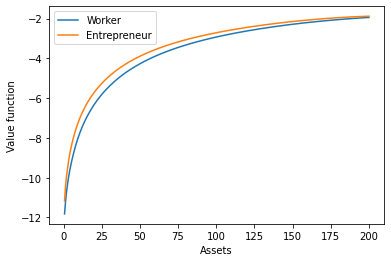

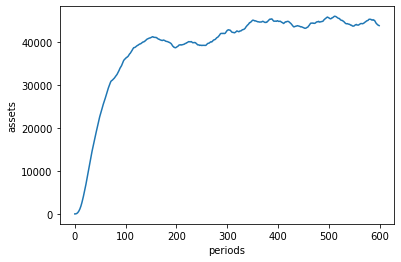

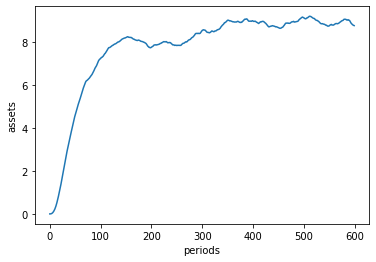

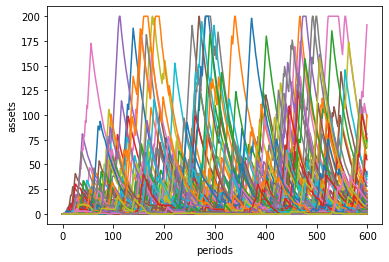

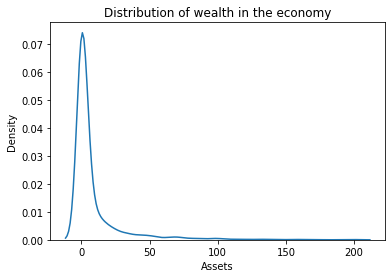

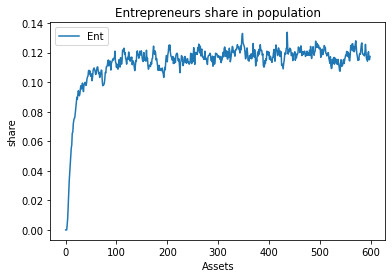

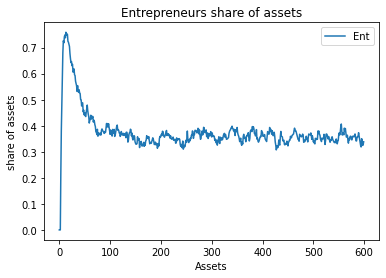

In [8]:
#Plot Value function
plt.plot(a[1:].T,V_worker[1:,3,3].T, label = "Worker")
plt.plot(a[1:].T,V_ent[1:,3,3].T, label = "Entrepreneur")
plt.xlabel('Assets')
plt.ylabel('Value function')
plt.legend()
plt.show()

#Plot aggregate assets from economy
plt.plot(Am_test[:,0], label = "Aggregate assets from the economy")
plt.xlabel('periods')
plt.ylabel('assets')
plt.show()

#Plot per capita assets from economy
plt.plot(Am_test[:,0]/number_ind, label = "Per capita assets in the economy")
plt.xlabel('periods')
plt.ylabel('assets')
plt.show()

#Plot indiviual assets
plt.plot(Am_test[:,1:200], label = "Individual households assets")
plt.xlabel('periods')
plt.ylabel('assets')
plt.show()

#Plot asset distribution
sns.kdeplot(Am_test[sim_size-1,1:number_ind])
plt.xlabel('Assets')
plt.ylabel('Density')
plt.title("Distribution of wealth in the economy")
plt.show()

#entrepreneur share
# plt.plot((ent_share[:,0]/number_ind).T, label = "workers")
plt.plot(((number_ind - ent_share[:,0])/number_ind).T, label = "Ent")
plt.xlabel('Assets')
plt.ylabel('share')
plt.title("Entrepreneurs share in population")
plt.legend()
plt.show()

#entrepreneur share of aggregate assets
# plt.plot((Ent_Am[:,0]).T, label = "workers")
plt.plot(((Ent_Am[:,0])/Am_test[:,0]).T, label = "Ent")
plt.xlabel('Assets')
plt.ylabel('share of assets')
plt.title("Entrepreneurs share of assets")
plt.legend()
plt.show()

Now, we provide some wealth distribution analyzes. Basically, we are going to see how the average assets change for different wealth distributions in equilibrium:

In [9]:
#Average assets of entrepreneurs
print("Average assets of entrepreneurs is ",Ent_Am[sim_size-1,0]/(number_ind - ent_share[sim_size-1,0]))
#Average assets of workers
print("Average assets of workers is ",(Am_test[sim_size-1,0]-Ent_Am[sim_size-1,0])/ent_share[sim_size-1,0])


#Gini analysis
wealth_gini = qe.gini_coefficient(Am_test[sim_size-1,1:])
print("Wealth Gini is ",wealth_gini)

#Wealth distribution
wealth_dist = Am_test[sim_size-1,1:]
wealth_dist = sorted(wealth_dist,reverse= True)
print(
# 1%
"Percentage wealth with the top 1% is ",
sum(wealth_dist[:int(number_ind/100)])/sum(wealth_dist))
# 5%
print(
"Percentage wealth with the top 5% is ",
sum(wealth_dist[:int(number_ind/20)])/sum(wealth_dist))
# 10%
print(
"Percentage wealth with the top 10% is ",
sum(wealth_dist[:int(number_ind/10)])/sum(wealth_dist))
# 20%
print(
"Percentage wealth with the top 20% is ",
sum(wealth_dist[:int(number_ind/5)])/sum(wealth_dist))
# 40%
print(
"Percentage wealth with the top 40% is ",
sum(wealth_dist[:int(number_ind/2.5)])/sum(wealth_dist))
# 60%
print(
"Percentage wealth with the top 60% is ",
sum(wealth_dist[:int(number_ind/(10/6))])/sum(wealth_dist))


Average assets of entrepreneurs is  25.248006455362283
Average assets of workers is  6.568671125217352
Wealth Gini is  0.828326528768146
Percentage wealth with the top 1% is  0.164215977083847
Percentage wealth with the top 5% is  0.4904820589656443
Percentage wealth with the top 10% is  0.6961113075526546
Percentage wealth with the top 20% is  0.8836528569528869
Percentage wealth with the top 40% is  0.9846933828183397
Percentage wealth with the top 60% is  0.9999543691948114


Thus, our baseline equilibrium shows a Gini coefficient of 0.83, while the entrepreneurs share of population is around $12\%$. Moreover, entrepreneurs share of assets converge in this exercise to 0.35. 

These results do not match exactly the numbers on Kitao (2008), but goes closely. Probably because here we have a different asset grid upper bound.

Now, let's do some comparative stats. In our baseline, we have setted $\tau_e = 0.10$. Let's raise it until $\tau_e' = 0.6$.

Doing the same exercise as before:

In [28]:
# Changing the tax parameter
tau_e = 0.60

In [29]:
# Running our algorithm again
erro_k = 100
iter_k = 0
r      = 0.04
r_new  = 0.04
ind_a  = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(int)
prof   = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(float)


#worker grids
V_worker     = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(float)
V_worker_new = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(float)
ga_worker    = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(float)
gc_worker    = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(float)
util_worker  = np.repeat(0,a_grid*z_grid*s_grid*a_grid).reshape(a_grid,z_grid,s_grid,a_grid).astype(float)
ind_a_worker = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(int)

#entrepreneur grids
V_ent     = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(float)
V_ent_new = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(float)
ga_ent    = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(float)
gc_ent    = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(float)
util_ent  = np.repeat(0,a_grid*z_grid*s_grid*a_grid).reshape(a_grid,z_grid,s_grid,a_grid).astype(float)
ind_a_ent = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(int)

#Grid for choice between being worker and entrepreneur: if 1, he chooses to be a worker
worker = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(int)
worker_array_ent = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(int)
worker_array_worker = np.repeat(0,a_grid*z_grid*s_grid).reshape(a_grid,z_grid,s_grid).astype(int)


# Interpolation grid
a_interp = np.linspace(grid_min, grid_max, 3*grid_max)
ga_worker_interp = np.repeat(0,3*grid_max*z_grid*s_grid).reshape(3*grid_max,z_grid,s_grid).astype(float)
gc_worker_interp = np.repeat(0,3*grid_max*z_grid*s_grid).reshape(3*grid_max,z_grid,s_grid).astype(float)
ga_ent_interp = np.repeat(0,3*grid_max*z_grid*s_grid).reshape(3*grid_max,z_grid,s_grid).astype(float)
gc_ent_interp = np.repeat(0,3*grid_max*z_grid*s_grid).reshape(3*grid_max,z_grid,s_grid).astype(float)


start_time = datetime.now()
while abs(erro_k)>1e-2 and iter_k<100:
    iter_k = iter_k + 1
    erro_v_worker = 100
    erro_v_ent = 100
    iter_v = 0
    r = 0.9*r + 0.1*r_new
    K = ((alpha*(N**(1-alpha)))/(r+delta))**(1/(1-alpha))
    Y = (K**alpha)*(N**(1-alpha))
    w = (1-alpha)*(K**(alpha)*N**(-alpha))
    profit(a,z,s,prof,r,w, alpha = alpha, phi = phi, d= d, tau_e = tau_e)
    utility_entrepreneur(util_ent, r, w,prof)
    utility_worker(util_worker, r, w)
    while (erro_v_worker > 1e-3 or erro_v_ent > 1e-3) and iter_v<200:
        update_ent(V_ent,V_worker,V_ent_new,ga_ent,gc_ent,ind_a_ent,worker_array_ent,r,w)
        update_worker(V_worker,V_ent,V_worker_new,ga_worker,gc_worker,ind_a_worker,worker_array_worker,r,w)
        erro_v_worker = np.max(abs(V_worker_new - V_worker))
        erro_v_ent = np.max(abs(V_ent_new - V_ent))
        # print(iter_v)
        # print(erro_v_worker)
        # print(erro_v_ent)
        # print("----------//------------")
        iter_v = iter_v + 1
        V_worker = deepcopy(V_worker_new)
        V_ent = deepcopy(V_ent_new)
    
    
    for jz in range(z_grid):
        for js in range(s_grid):
            ga_worker_interp[:,jz,js] = np.interp(a_interp, a, ga_worker[:,jz,js])
            gc_worker_interp[:,jz,js] = np.interp(a_interp, a, gc_worker[:,jz,js])
            ga_ent_interp[:,jz,js]    = np.interp(a_interp, a, ga_ent[:,jz,js])
            gc_ent_interp[:,jz,js]    = np.interp(a_interp, a, gc_ent[:,jz,js])
    
    # Create Household parameters and populate world
    sim_size = 600
    household_asset = np.repeat(0.001,sim_size).astype(float)
    household_cons = np.repeat(0,sim_size).astype(float)
    number_ind = 5000
    # test = list()
    test = np.repeat(0,sim_size*number_ind*3).reshape(sim_size,3,number_ind).astype(float)
    populate(number_ind,sim_size,tauchen_approx_z,pi_s,z,s)
    
    # Obtain Aggregate data
    Am_test = np.repeat(0,sim_size*number_ind).reshape(sim_size,number_ind).astype(float)
    Am_test_update(Am_test, test)
    Am = Am_test[sim_size-1,0]/number_ind

    erro_k = (K-Am)/K
    K = Am
    r_new = alpha*((K/N)**(alpha-1))-delta
    
    
    print("erro_k = "+str(erro_k))
    print("iter_k = "+str(iter_k))
    print("r_new = "+str(r_new))
    print("r = "+str(r))
    print("Am = "+str(Am))
    print("savings rate is "+ str(delta*alpha/(r+delta)))
    print("--------------------------------")

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

erro_k = -0.09009623795535616
iter_k = 1
r_new = 0.034628618949451476
r = 0.04000000000000001
Am = 8.37339960936437
savings rate is 0.21599999999999997
--------------------------------
erro_k = -0.07999400337470373
iter_k = 2
r_new = 0.03468284326379045
r = 0.03946286189494516
Am = 8.365908008026622
savings rate is 0.21716648393663143
--------------------------------
erro_k = -0.11935747934232302
iter_k = 3
r_new = 0.03209344894143784
r = 0.03898486003182969
Am = 8.736340938461334
savings rate is 0.21821518960631228
--------------------------------
erro_k = -0.12660063292232418
iter_k = 4
r_new = 0.031075551390791517
r = 0.0382957189227905
Am = 8.889383651504758
savings rate is 0.2197450737093281
--------------------------------
erro_k = -0.13833491007424406
iter_k = 5
r_new = 0.02980901812838975
r = 0.037573702169590606
Am = 9.086038186621868
savings rate is 0.22137112274839726
--------------------------------
erro_k = -0.09890397117547148
iter_k = 6
r_new = 0.03112734368042791
r = 0.

In [30]:
# Function for obtaining the share of entrepreneurs in the economy
@jit
def ent_share_update(ent_share, test):
    for t in range(0,sim_size):
        for i in range(0,number_ind):
            ent_share[t,0] = ent_share[t,0] + test[t,2,i]
            ent_share[t,i] = test[t,2,i]


ent_share = np.repeat(0,sim_size*number_ind).reshape(sim_size,number_ind).astype(float)
ent_share_update(ent_share, test)

# Function for obtaining of the share of the entrepreneurs assets from aggregate assets
@jit
def Ent_Am_update(Ent_Am, test):
    for t in range(0,sim_size):
        for i in range(0,number_ind):
            if test[t,2,i] == 0:
                Ent_Am[t,0] = Ent_Am[t,0] + test[t,0,i]
                Ent_Am[t,i] = test[t,0,i]

Ent_Am = np.repeat(0,sim_size*number_ind).reshape(sim_size,number_ind).astype(float)
Ent_Am_update(Ent_Am, test)

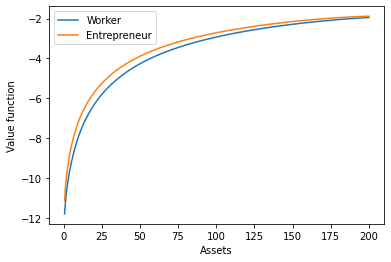

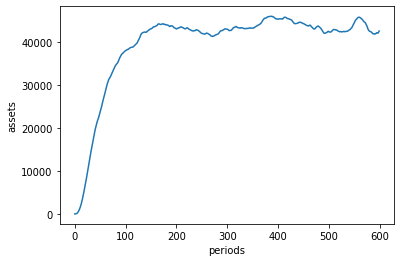

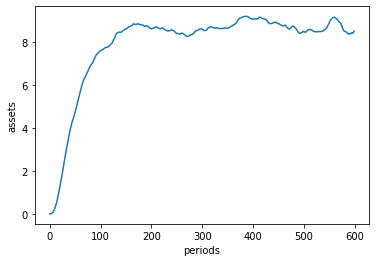

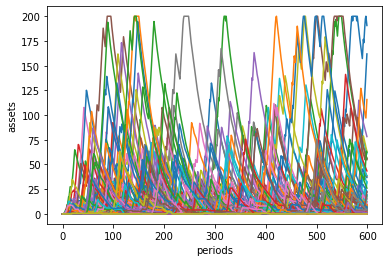

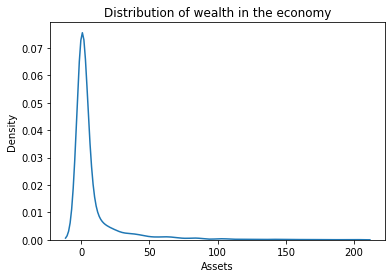

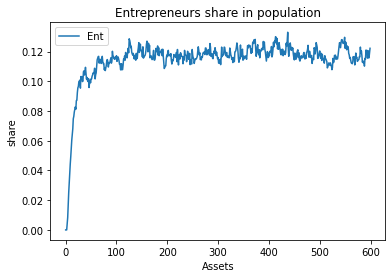

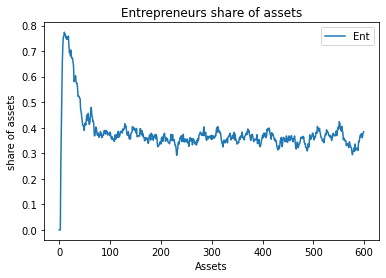

In [31]:
#Plot Value function
plt.plot(a[1:].T,V_worker[1:,3,3].T, label = "Worker")
plt.plot(a[1:].T,V_ent[1:,3,3].T, label = "Entrepreneur")
plt.xlabel('Assets')
plt.ylabel('Value function')
plt.legend()
plt.show()

#Plot aggregate assets from economy
plt.plot(Am_test[:,0], label = "Aggregate assets from the economy")
plt.xlabel('periods')
plt.ylabel('assets')
plt.show()

#Plot per capita assets from economy
plt.plot(Am_test[:,0]/number_ind, label = "Per capita assets in the economy")
plt.xlabel('periods')
plt.ylabel('assets')
plt.show()

#Plot indiviual assets
plt.plot(Am_test[:,1:200], label = "Individual households assets")
plt.xlabel('periods')
plt.ylabel('assets')
plt.show()

#Plot asset distribution
sns.kdeplot(Am_test[sim_size-1,1:number_ind])
plt.xlabel('Assets')
plt.ylabel('Density')
plt.title("Distribution of wealth in the economy")
plt.show()

#entrepreneur share
# plt.plot((ent_share[:,0]/number_ind).T, label = "workers")
plt.plot(((number_ind - ent_share[:,0])/number_ind).T, label = "Ent")
plt.xlabel('Assets')
plt.ylabel('share')
plt.title("Entrepreneurs share in population")
plt.legend()
plt.show()

#entrepreneur share of aggregate assets
# plt.plot((Ent_Am[:,0]).T, label = "workers")
plt.plot(((Ent_Am[:,0])/Am_test[:,0]).T, label = "Ent")
plt.xlabel('Assets')
plt.ylabel('share of assets')
plt.title("Entrepreneurs share of assets")
plt.legend()
plt.show()

In [32]:
#Average assets of entrepreneurs
print("Average assets of entrepreneurs is ",Ent_Am[sim_size-1,0]/(number_ind - ent_share[sim_size-1,0]))
#Average assets of workers
print("Average assets of workers is ",(Am_test[sim_size-1,0]-Ent_Am[sim_size-1,0])/ent_share[sim_size-1,0])


#Gini analysis
wealth_gini = qe.gini_coefficient(Am_test[sim_size-1,1:])
print("Wealth Gini is ",wealth_gini)

#Wealth distribution
wealth_dist = Am_test[sim_size-1,1:]
wealth_dist = sorted(wealth_dist,reverse= True)
print(
# 1%
"Percentage wealth with the top 1% is ",
sum(wealth_dist[:int(number_ind/100)])/sum(wealth_dist))
# 5%
print(
"Percentage wealth with the top 5% is ",
sum(wealth_dist[:int(number_ind/20)])/sum(wealth_dist))
# 10%
print(
"Percentage wealth with the top 10% is ",
sum(wealth_dist[:int(number_ind/10)])/sum(wealth_dist))
# 20%
print(
"Percentage wealth with the top 20% is ",
sum(wealth_dist[:int(number_ind/5)])/sum(wealth_dist))
# 40%
print(
"Percentage wealth with the top 40% is ",
sum(wealth_dist[:int(number_ind/2.5)])/sum(wealth_dist))
# 60%
print(
"Percentage wealth with the top 60% is ",
sum(wealth_dist[:int(number_ind/(10/6))])/sum(wealth_dist))

Average assets of entrepreneurs is  26.741392546896645
Average assets of workers is  5.971201290699912
Wealth Gini is  0.8326193010441645
Percentage wealth with the top 1% is  0.16894358715909852
Percentage wealth with the top 5% is  0.5003087212806159
Percentage wealth with the top 10% is  0.7071613601156803
Percentage wealth with the top 20% is  0.8882839053471788
Percentage wealth with the top 40% is  0.9847740607593098
Percentage wealth with the top 60% is  0.9999530162138833


Here, similar to the original paper, an increase in $\tau_e = 10\%$ to $\tau_e' = 50\%$ decreases the share of entrepreneurs, but in this exercise quite small. Again, probably because I used a smaller bounder for grid assets. 

